In [47]:
import os
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import ImageDraw
import matplotlib.pyplot as plt

# Path ke dataset
train_dir = "test/dataset2/train"  # Ganti dengan path folder "train"
train_annotations = "test/dataset2/train/_annotations.coco.json"  # Path ke file COCO

# Transformasi gambar
transform = transforms.Compose([
    transforms.ToTensor(),  # Mengubah gambar dari PIL ke Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi
])

class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile)
        self.transform = transform

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        # Debug target untuk memastikan formatnya
        print(f"Raw target: {target}")

        # Ubah bounding box dari [x, y, width, height] menjadi [x_min, y_min, x_max, y_max]
        boxes = []
        labels = []
        for t in target:
            bbox = t["bbox"]
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(t["category_id"])

        # Pastikan bounding box dan label berupa tensor
        target_dict = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transform:
            img = self.transform(img)

        return img, target_dict


In [48]:
# Debug dataset
img, target = dataset[0]
print(f"Type of img: {type(img)}")  # Harus <class 'torch.Tensor'>
print(f"Shape of img: {img.shape}")  # Harus [C, H, W] untuk RGB
print(f"Target: {target}")  # Harus dictionary dengan kunci 'boxes' dan 'labels'


Type of img: <class 'torch.Tensor'>
Shape of img: torch.Size([3, 640, 640])
Target: {'boxes': tensor([[ 97.0000,  42.0000, 546.5000, 640.0000]]), 'labels': tensor([3])}


In [49]:
def visualize_sample(dataset, idx=0):
    img, target = dataset[idx]
    img = transforms.ToPILImage()(img)  # Ubah tensor menjadi gambar PIL untuk visualisasi
    draw = ImageDraw.Draw(img)

    # Dapatkan bounding boxes dan labels
    boxes = target["boxes"]
    labels = target["labels"]

    for box in boxes:
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=2)

    plt.imshow(img)
    plt.axis("off")
    plt.show()


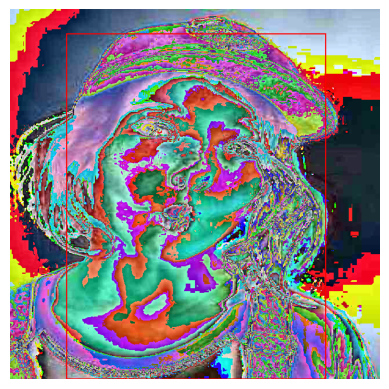

In [50]:
visualize_sample(dataset, idx=0)


In [51]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()  # Set model ke mode pelatihan
    for batch_idx, (images, targets) in enumerate(data_loader):
        # Pindahkan gambar dan target ke perangkat (CPU/GPU)
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass dan update parameter
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Logging loss
        print(f"Epoch [{epoch}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {total_loss.item():.4f}")


In [52]:
def train_model(model, optimizer, data_loader, device, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_one_epoch(model, optimizer, data_loader, device, epoch)
        print("-" * 50)


In [53]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Scheduler untuk mengurangi learning rate setelah beberapa epoch
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


In [54]:
from torch.utils.data import DataLoader

# DataLoader dengan collate_fn untuk batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [55]:
# Tentukan jumlah epoch
num_epochs = 5

# Jalankan training loop
train_model(model, optimizer, train_loader, device, num_epochs)


Epoch 1/5
Epoch [0], Batch [1/33], Loss: 2.4137
Epoch [0], Batch [2/33], Loss: 0.2455
Epoch [0], Batch [3/33], Loss: 0.4922
Epoch [0], Batch [4/33], Loss: 0.2458
Epoch [0], Batch [5/33], Loss: 0.5046
Epoch [0], Batch [6/33], Loss: 0.6058
Epoch [0], Batch [7/33], Loss: 0.2467
Epoch [0], Batch [8/33], Loss: 0.3924
Epoch [0], Batch [9/33], Loss: 0.2976
Epoch [0], Batch [10/33], Loss: 0.2420
Epoch [0], Batch [11/33], Loss: 0.2840
Epoch [0], Batch [12/33], Loss: 0.3020
Epoch [0], Batch [13/33], Loss: 0.2083
Epoch [0], Batch [14/33], Loss: 0.1824
Epoch [0], Batch [15/33], Loss: 0.1979
Epoch [0], Batch [16/33], Loss: 0.1681
Epoch [0], Batch [17/33], Loss: 0.1868
Epoch [0], Batch [18/33], Loss: 0.1744
Epoch [0], Batch [19/33], Loss: 0.1721
Epoch [0], Batch [20/33], Loss: 0.1779
Epoch [0], Batch [21/33], Loss: 0.2219
Epoch [0], Batch [22/33], Loss: 0.1866
Epoch [0], Batch [23/33], Loss: 0.2036
Epoch [0], Batch [24/33], Loss: 0.2139
Epoch [0], Batch [25/33], Loss: 0.2338
Epoch [0], Batch [26/33]

In [56]:
# Simpan model ke file
torch.save(model.state_dict(), "fasterrcnn_model.pth")
print("Model telah disimpan.")


Model telah disimpan.


Gambar acak yang dipilih: test/dataset2/test\35f2bca26925681cdcd15af1ad6aa246_jpg.rf.f35bc41488cc6f8be325a77af374d804.jpg
Deteksi: fair skin dengan skor 0.67


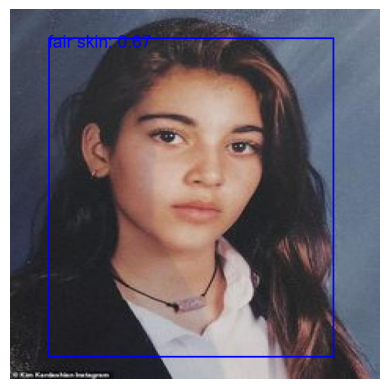

In [63]:
    import os
    import random
    from PIL import Image, ImageDraw, ImageFont
    import torch
    import matplotlib.pyplot as plt

    # Fungsi untuk memilih gambar acak
    def get_random_image(folder_path):
        """Mengambil path ke gambar secara acak dari folder."""
        all_files = os.listdir(folder_path)
        image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) == 0:
            raise FileNotFoundError("Tidak ada file gambar di folder.")
        random_image = random.choice(image_files)
        return os.path.join(folder_path, random_image)

    # Path ke folder dataset
    test_folder_path = "test/dataset2/test"

    # Ambil gambar acak
    random_image_path = get_random_image(test_folder_path)
    print(f"Gambar acak yang dipilih: {random_image_path}")

    # Fungsi untuk menguji model
    def test_model(model, image_path, device):
        model.eval()  # Set model ke mode evaluasi
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).to(device)
        with torch.no_grad():
            prediction = model([img_tensor])
        return img, prediction

    # Visualisasi hasil prediksi dengan label
    def visualize_prediction_with_labels(img, prediction, threshold=0.5, categories=None):
        """
        Visualisasikan prediksi dengan bounding box dan label.
        """
        draw = ImageDraw.Draw(img)
        
        # Gunakan font default atau font custom dengan ukuran lebih besar
        try:
            font = ImageFont.truetype("arial.ttf", 30)  # Ukuran font 30
        except IOError:
            font = ImageFont.load_default()  # Jika font tidak ada, gunakan font default
        
        for box, label, score in zip(prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]):
            if score > threshold:  # Threshold confidence score
                # Gambar bounding box
                box = [int(coord) for coord in box.tolist()]  # Pastikan koordinat integer
                draw.rectangle(box, outline="blue", width=3)

                # Ambil label kategori
                label_text = f"{categories[label]}: {score:.2f}" if categories else f"Label {label}: {score:.2f}"
                
                # Print kategori warna kulit di terminal
                print(f"Deteksi: {categories[label]} dengan skor {score:.2f}")
                
                # Posisi teks sedikit di atas bounding box
                text_position = (box[0], box[1] - 10)
                
                # Tambahkan label dengan ukuran font lebih besar
                draw.text(text_position, label_text, fill="blue", font=font)
        
        # Convert image to RGB for proper display in matplotlib
        img_rgb = img.convert("RGB")
        
        # Tampilkan gambar dengan matplotlib
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()

    # Daftar kategori dari dataset
    categories = ["background", "skin", "dark skin", "fair skin", "light skin", "medium skin"]

    # Jalankan model pada gambar acak
    img, prediction = test_model(model, random_image_path, device)

    # Visualisasi prediksi dengan label
    visualize_prediction_with_labels(img, prediction, categories=categories)


Gambar acak yang dipilih: test/dataset2/test\1a1a82314b9a22d0fd2c33443295147a_jpg.rf.4799ce3ada6b81a5c3e9af495308bfc8.jpg


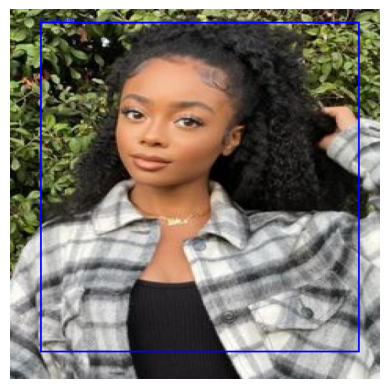

In [61]:
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Fungsi untuk memilih gambar acak
def get_random_image(folder_path):
    """Mengambil path ke gambar secara acak dari folder."""
    all_files = os.listdir(folder_path)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) == 0:
        raise FileNotFoundError("Tidak ada file gambar di folder.")
    random_image = random.choice(image_files)
    return os.path.join(folder_path, random_image)

# Path ke folder dataset
test_folder_path = "test/dataset2/test"

# Ambil gambar acak
random_image_path = get_random_image(test_folder_path)
print(f"Gambar acak yang dipilih: {random_image_path}")

# Fungsi untuk menguji model
def test_model(model, image_path, device):
    model.eval()  # Set model ke mode evaluasi
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).to(device)
    with torch.no_grad():
        prediction = model([img_tensor])
    return img, prediction

# Visualisasi hasil prediksi dengan label
def visualize_prediction_with_labels(img, prediction, threshold=0.5, categories=None):
    """
    Visualisasikan prediksi dengan bounding box dan label.
    """
    draw = ImageDraw.Draw(img)
    for box, label, score in zip(prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]):
        if score > threshold:  # Threshold confidence score
            # Gambar bounding box
            draw.rectangle(box.tolist(), outline="blue", width=3)

            # Tambahkan label kategori
            label_text = f"{categories[label]}: {score:.2f}" if categories else f"Label {label}: {score:.2f}"
            text_position = (box[0], box[1] - 10)  # Posisi teks sedikit di atas bounding box
            draw.text(text_position, label_text, fill="blue")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Daftar kategori dari dataset
categories = ["background", "skin", "dark skin", "fair skin", "light skin", "medium skin"]

# Jalankan model pada gambar acak
img, prediction = test_model(model, random_image_path, device)

# Visualisasi prediksi dengan label
visualize_prediction_with_labels(img, prediction, categories=categories)


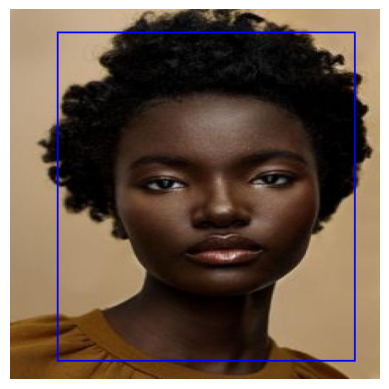

In [59]:
# Path ke gambar uji
test_image_path = "test/dataset2/test/1d2196d2a949f72d729f7c5412f580cf_jpg.rf.c8b4ef08abb352b20086bb35da3d544e.jpg"

# Jalankan prediksi
img, prediction = test_model(model, test_image_path, device)

# Visualisasi hasil
visualize_prediction(img, prediction)
